In [1]:
#библиотеки

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from statsmodels.stats.weightstats import *

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import RidgeCV, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_absolute_error, make_scorer
from hyperopt import fmin,tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import learning_curve, validation_curve
%matplotlib inline

будем предсказывать стоимость.

<b>Признаки</b>
- carat - вес бриллианта в каратах, вещественный
- cut - качество огранки, категориальный. Принимает пять возможных значений: Fair, Good, Very Good, Premium, Ideal
- color - "цвет" бриллианта. Категориальный признак, принимает значения J,I,H,G,F,E,D (от худшего (J) к лучшему (D))
- clarity - чистота бриллианта. Категориальный признак, принимает значения I1 (худший), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (лучший)
- x,y,z - три признака, характеризущие размеры бриллианта, вещественные
- depth - признак, который высчитывается на основе трех предыдущих по формуле 2 * z / (x + y), вещественный
- table - отношение ширины верхней грани бриллианты к его максимальной ширине, в процентах


<b>Целевой признак</b>: price - стоимость бриллианта в долларах



###  EDA анализ данных

In [16]:
#загрузка датасета трейн 
data_diamonds_train = pd.read_csv('train.csv')
data_diamonds_train = data_diamonds_train[(data_diamonds_train['x'] != 0)&(data_diamonds_train['y'] != 0)&data_diamonds_train['z'] != 0]
data_diamonds_train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03


In [17]:
data_diamonds_train.describe()

,carat,depth,table,price,x,y,z
count,40441.000000,40441.000000,40441.000000,40441.000000,40441.000000,40441.000000,40441.000000
mean,0.797053,61.746339,57.451386,3936.957667,5.729582,5.733482,3.538755
std,0.474339,1.420502,2.230358,3997.160250,1.120716,1.150841,0.706623
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.710000,1.070000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.000000,6.540000,6.530000,4.030000
max,5.010000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.800000


Видно, что масштабы признаков отличаются. В дальнейшем нужно будет применить StandartScaler

In [18]:
data_diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40441 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40441 non-null  float64
 1   cut      40441 non-null  object 
 2   color    40441 non-null  object 
 3   clarity  40441 non-null  object 
 4   depth    40441 non-null  float64
 5   table    40441 non-null  float64
 6   price    40441 non-null  int64  
 7   x        40441 non-null  float64
 8   y        40441 non-null  float64
 9   z        40441 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


В данных отсутствуют пропуски. Итого, имеется 6 вещественных, 1 целочисленный и 3 категориальных признака.

### Анализ целочисленных и вещественных признаков

In [19]:
real_features = ['carat', 'depth', 'table', 'x', 'y', 'z','price']

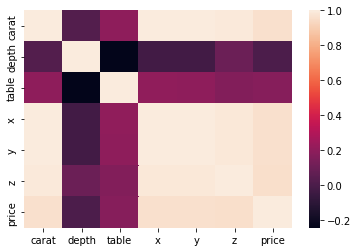

In [20]:
# Изучим корреляцию вещественных признаков и целевой переменной
sns.heatmap(data_diamonds_train[real_features].corr(method='spearman'));

Признаки carat, x,y,z имеют большую корреляцию, как между собой, так и с целевой переменной, что не удивительно(чем больше карат - тем дороже бриллиант). При этом, корреляция целевой переменной и признаков depth, table почти отсутствует

#### Анализ категориальных признаков

In [21]:
cat_features = ['cut','color','clarity']

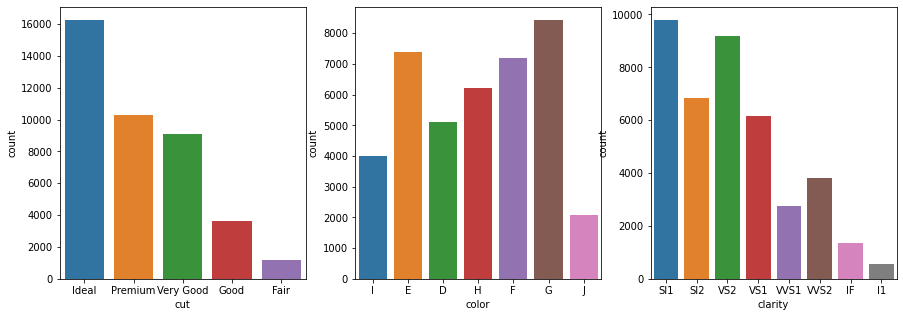

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for idx, feature in enumerate(cat_features):
    sns.countplot(data_diamonds_train[feature], ax=axes[idx % 3], label=feature)

Реальные значения категориальных признаков не отличаются от тех, что заявлены в описании. Кроме того, видно, что уникальных значений не много, так что One Hot encoding должен отлично сработать. 

#### Анализ целевого признака

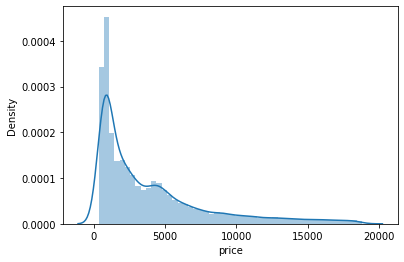

In [28]:
sns.distplot(data_diamonds_train['price'])

Распределение имеет тяжелый правый хвост. Применим логарифмирование.

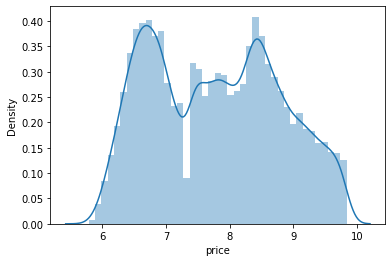

In [29]:
sns.distplot(data_diamonds_train['price'].map(np.log1p))

Помогло это не сильно: получилось бимодальное распределение. Зато хвост исчез =) Для наглядности, построим QQ график

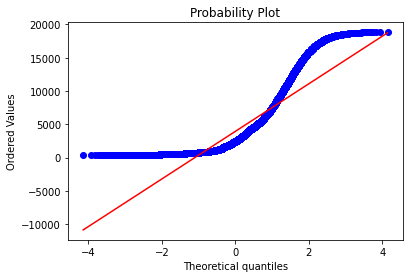

In [31]:
stats.probplot(data_diamonds_train['price'], dist="norm", plot=plt);

#### Выводы
- Вещественные признаки (carat, depth, table, x, y, z) масштабируем
- К категориальным признакам ('cut','color','clarity') применяем one hot encoding
- Целевую переменную логарифмируем

#### Анализ целочисленных и вещественных признаков

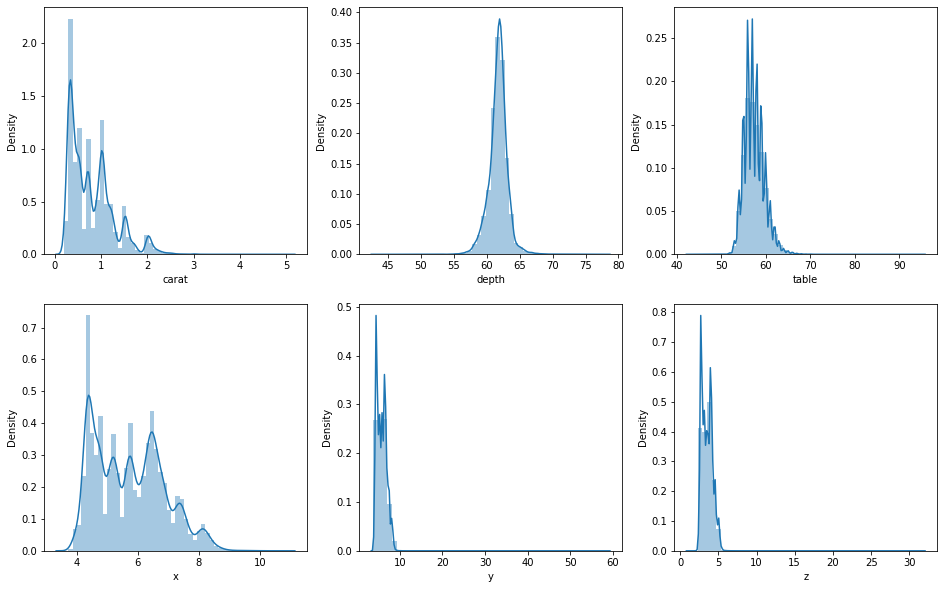

In [32]:
# Начнем с построения гистограмм вещественных признаков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

for idx, feature in enumerate(real_features[:-1]): #price рисовать не будем
    sns.distplot(data_diamonds_train[feature], ax=axes[idx // 3, idx % 3], label=feature)

Распределение признаков depth, table, y, z отдаленно, но напоминает колокол. У depth хвосты тяжеловаты для нормального распределения; carat и table скорее бимодальные. Кроме того, у них тяжелые правые хвосты, так что np.log1p не помешает. По графикам выше не видно выбросов. Проверим, что это действительно так, с помощью boxplot

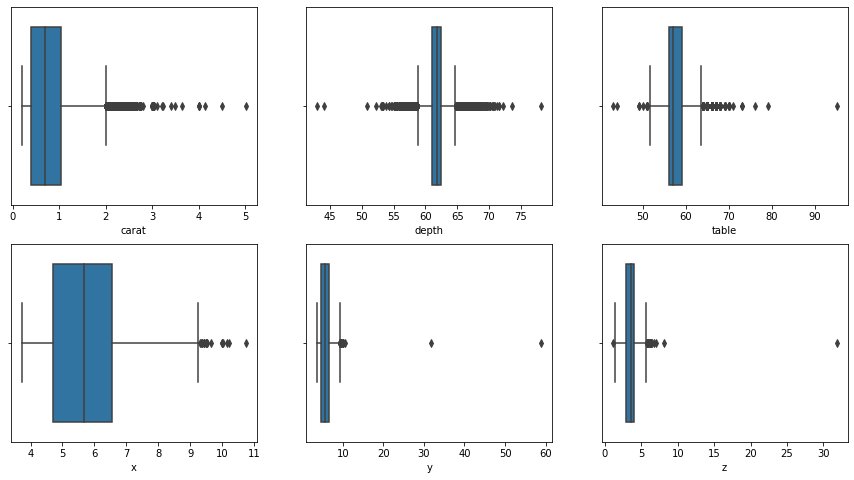

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for idx, feature in enumerate(real_features[:-1]): #price рисовать не будем
    sns.boxplot(data_diamonds_train[feature], ax=axes[idx // 3, idx % 3], orient='v')

Каких-либо серьезных аномалий в рассматриваемых данных нет. 

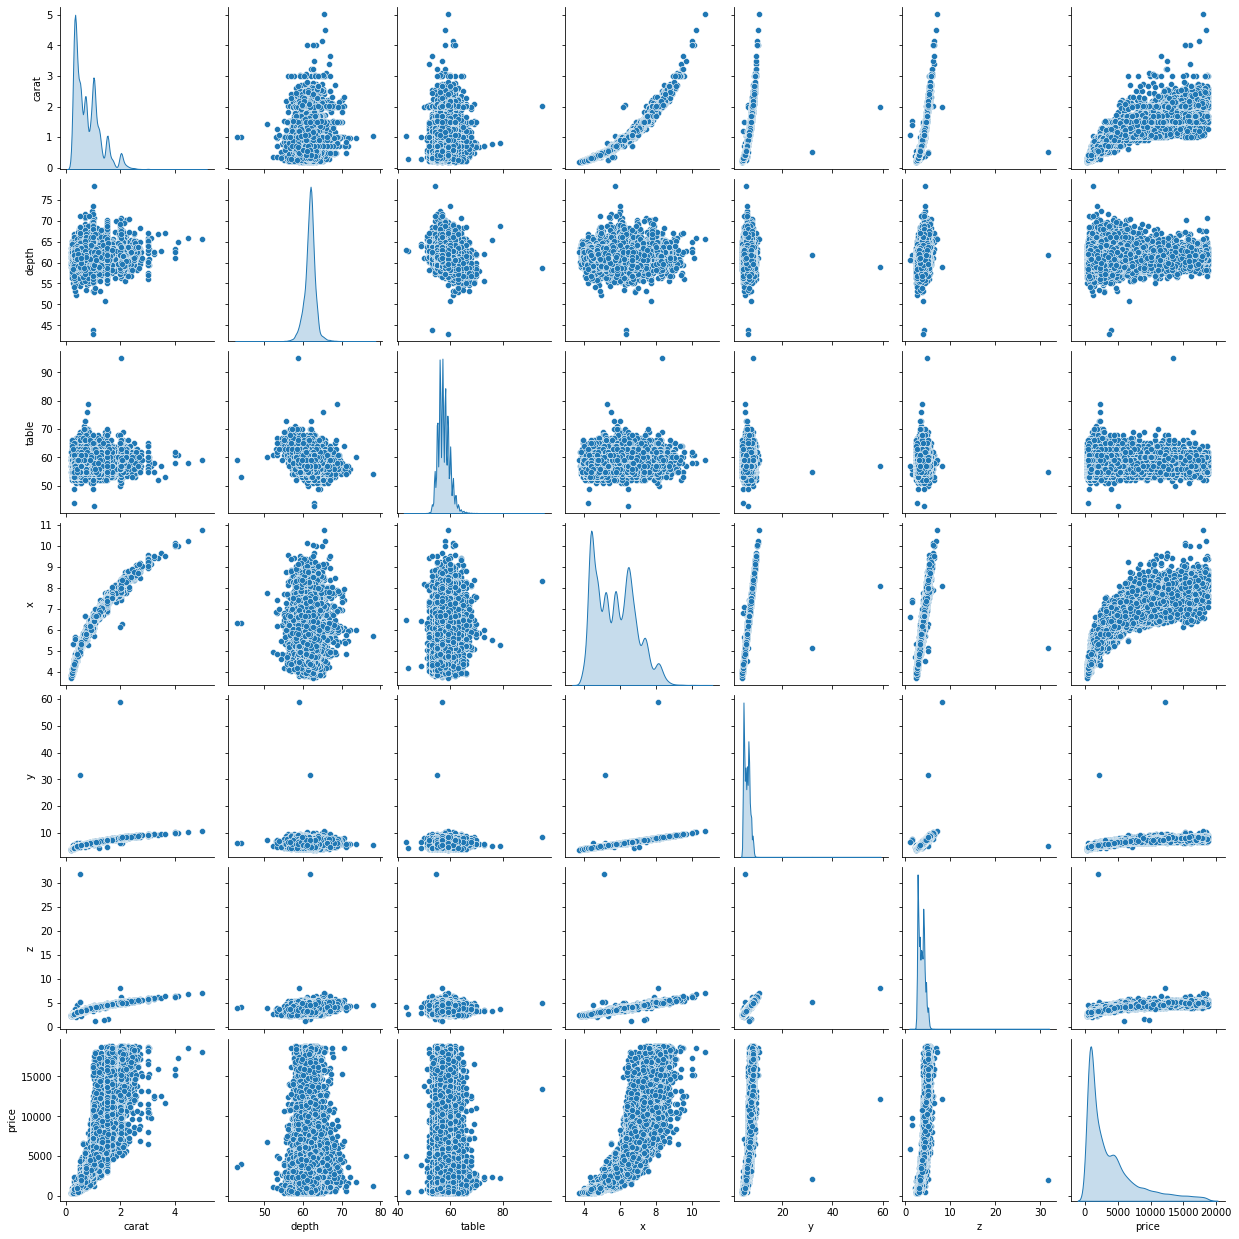

In [35]:
sns.pairplot(data_diamonds_train[real_features], diag_kind="kde")

- вес бриллианта показывает степенную зависимость от его размеров
- depth и table почти никак не взаимосвязаны с остальными признаками, в том числе и целевым
- x,y,z связаны между собой линейно
- цена линейно зависит от размеров
- зависимость между ценой и весом сложно назвать линейной, но монотонный тренд есть

#### Анализ категориальных признаков

Посмотрим, как целевая переменная зависит от категориальных признаков

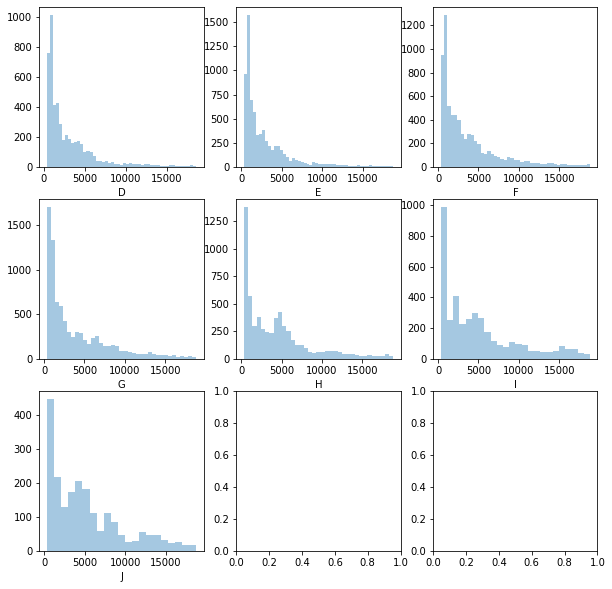

In [49]:
# цвет бриллианта
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for idx, (color, sub_df) in  enumerate(data_diamonds_train.groupby('color')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=color)

Распределения для всех значений цветов имеют тяжелый правый хвост и не сильно отличаются друг от друга.

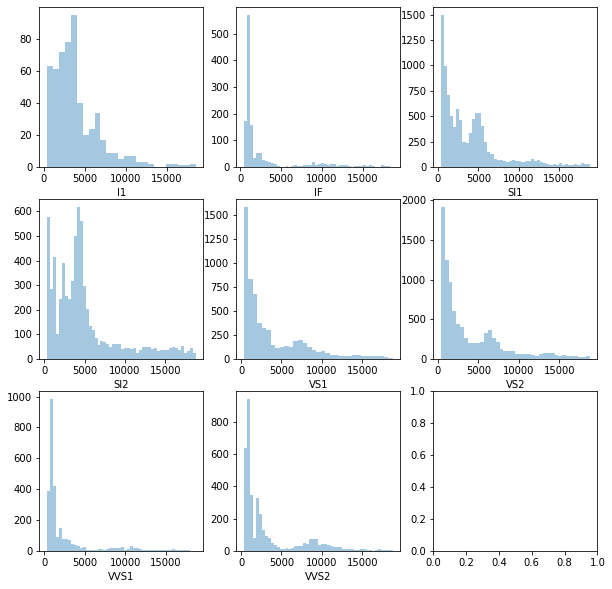

In [48]:
# чистота бриллианта
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for idx, (clarity, sub_df) in  enumerate(data_diamonds_train.groupby('clarity')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=clarity)

Хвосты у всех тяжелые, но у SI1,SI2 присутствуют дополнительные пики в районе 5000.

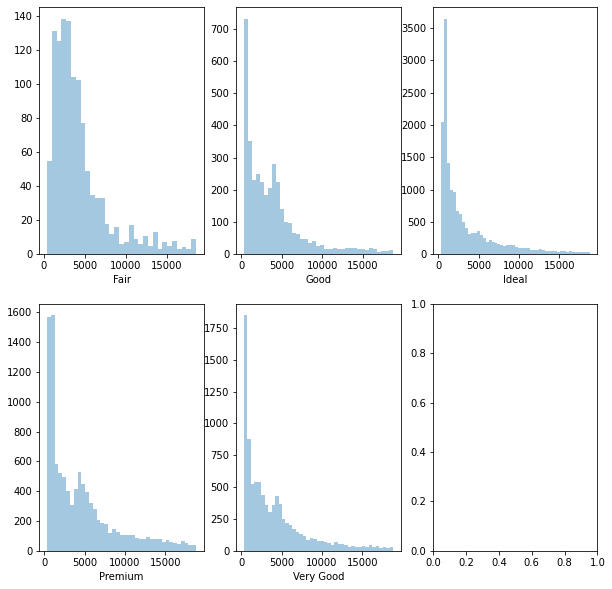

In [47]:
# качество огранки
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))

for idx, (cut, sub_df) in  enumerate(data_diamonds_train.groupby('cut')): 
    ax = sns.distplot(sub_df['price'], kde=False,  ax=axes[idx // 3, idx % 3])
    ax.set(xlabel=cut)

И снова пики в районе 5000 (у Good и Premium). А в целом графики похожи.

Нарисуем boxplot для каждого значения

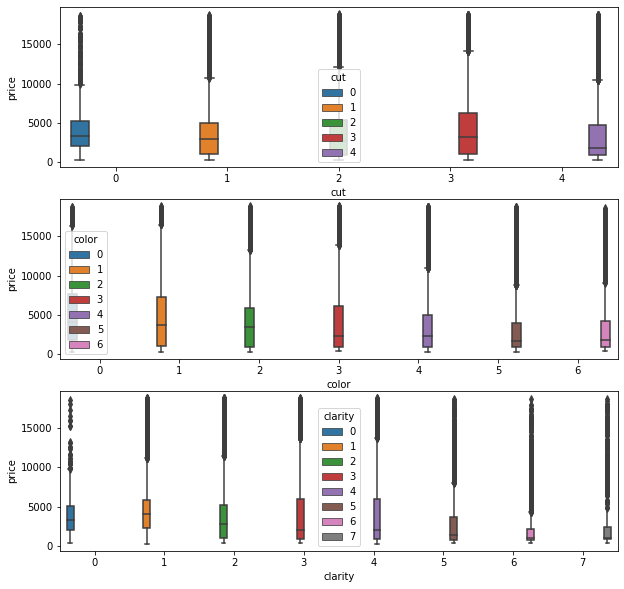

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# Отобразим строки в числа в порядке от худшего к лучшему. Так удобнее на графике смотреть
df = data_diamonds_train.copy()
df['color'] = df['color'].map({'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6})
df['clarity'] = df['clarity'].map({'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7 })
df['cut'] = df['cut'].map({'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4})

for idx, feature in enumerate(cat_features):
    sns.boxplot(x=feature, y='price',data=df,hue=feature,  ax=axes[idx])

Тут уже интереснее. Начнем с огранки. Видно, что медиана максимальна для Very Good и Premium. Для ideal медианное значение цены гораздо меньше. Аналогичные наблюдения можно сделать для цвета и чистоты. Возможно, бриллианты с наилучшими свойствами на очень большие, и, соответсвенно, их цена ниже. Проверим это.

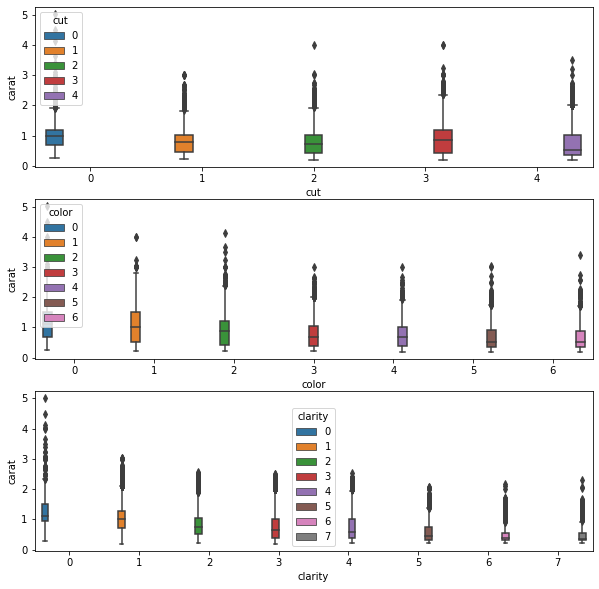

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

for idx, feature in enumerate(cat_features):
    sns.boxplot(x=feature, y='carat',data=df,hue=feature,  ax=axes[idx])

Действительно, медианное значение веса для бриллиантов с очень хорошими характеристиками меньше, чем для бриллиантов с плохими харакетристиками. Напоследок, посмотрим сколько бриллиантов с той или иной харакеристикой присутствует в данных.

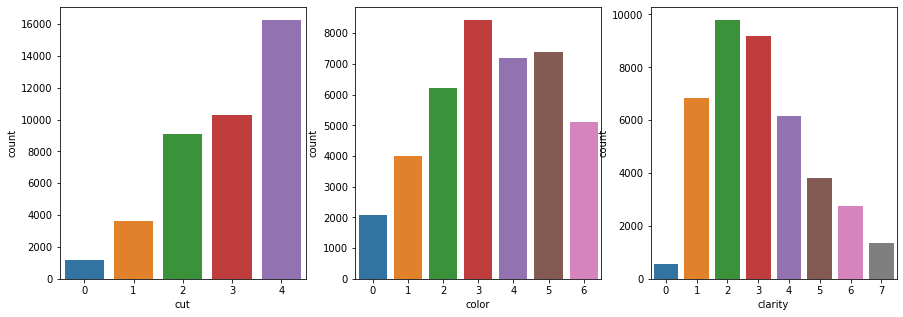

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for idx, feature in enumerate(cat_features):
    sns.countplot(df[feature], ax=axes[idx % 3], label=feature)

Видно, что очень мало камней с плохой огранкой. Также мало камней с плохими цветовыми харакеристиками. Но и не очень много с идеальными. Распределение чистоты камня напоминает лапласовское распределение.

#### Основные выводы по предыдущим пунктам:
- Ключевые признаки для прогнозирования: вес и размеры бриллианта (carat, x, y, z). По графикам видно, что есть монотонная зависимость этих признаков и цены. Что логично
- Признаки depth и table почти не влияют на стоимость камня
- Исключительно по категориальным признакам сложно что-либо сказать о целевой переменной. Однако видно, что чем лучше бриллиант с точки зрения этих признаков, тем больше вероятность того, что он будет не очень большого размера
- Выбросы в данных отсутствуют
- Так как у целевой переменной очень тяжелый правый хвост, в качестве метрики будем использовать среднюю абсолютную ошибку, а не квадратичную.
- Видно, что зависимость от ключевых признаков близка к линейной. Поэтому будем использовать линейную регрессию.

In [52]:
# Для начала, выделим выборку для тестирования
X = data_diamonds_train.drop(['price'], axis=1).values # отсекаем индекс
y = data_diamonds_train['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=4444, shuffle=True)

In [54]:
from sklearn.preprocessing import  PolynomialFeatures
# признаки с индексами 1,2,3 категориальные. Применим к ним ohe
label_bin = LabelBinarizer()
X_train_cut_ohe = label_bin.fit_transform(X_train[:,1])
X_test_cut_ohe = label_bin.transform(X_test[:,1])
                            
X_train_color_ohe = label_bin.fit_transform(X_train[:,2])
X_test_color_ohe = label_bin.transform(X_test[:,2])
                                                    
X_train_clarity_ohe = label_bin.fit_transform(X_train[:,3])
X_test_clarity_ohe = label_bin.transform(X_test[:,3])  

# carat, x и целевую переменную логарифмируем
log_vect = np.vectorize(np.log1p)
X_train_сarat_log = log_vect(X_train[:,0]).reshape(-1,1)
X_test_сarat_log  = log_vect(X_test[:,0]).reshape(-1,1)
X_train_x_log = log_vect(X_train[:,6]).reshape(-1,1)
X_test_x_log  = log_vect(X_test[:,6]).reshape(-1,1)
y_train_log = log_vect(y_train)
y_test_log = log_vect(y_test)

# масштабириуем вещественные признаки
scaler = StandardScaler()
X_train_real = np.hstack((X_train_сarat_log, X_train_x_log, X_train[:,[7,8,4,5]]))
X_test_real = np.hstack((X_test_сarat_log, X_test_x_log, X_test[:,[7,8,4,5]]))
X_train_real_scaled = scaler.fit_transform(X_train_real)
X_test_real_scaled = scaler.transform(X_test_real)

# В качестве дополнительных признаков будем рассматривать полиномиальные признаки
#Данные признаки должны улучшить качество линейной модели.

X_train_additional = PolynomialFeatures().fit_transform(X_train_real)
X_test_additional = PolynomialFeatures().fit_transform(X_test_real)
X_train_additional_scaled = scaler.fit_transform(X_train_additional)
X_test_additional_scaled = scaler.transform(X_test_additional)



# Объединяем все преобразованные признаки
X_train_transformed = np.hstack((X_train_real_scaled,X_train_cut_ohe, X_train_color_ohe, X_train_clarity_ohe))
X_test_transformed = np.hstack((X_test_real_scaled,X_test_cut_ohe, X_test_color_ohe, X_test_clarity_ohe))

Рассмотрим сначала линейную модель. Данные разделим на 5 фолдов. С помощью RidgeCV и LassoCV будем оптимизировать силу регуляризации.

In [55]:
# функция потерь для рассматриваемой задачи. Ошибку смотрим на исходных данных
def mean_absolute_exp_error(model, X,y):
    return -mean_absolute_error(np.expm1(model.predict(X)), np.expm1(y))

In [56]:
cv = KFold(n_splits=5, shuffle=True, random_state=4444)
alphas = np.logspace(-5,2,100)
ridge_cv = RidgeCV(alphas=alphas, scoring=mean_absolute_exp_error, cv=cv)
lasso_cv = LassoCV(alphas=alphas, cv=cv, random_state=4444)

In [57]:
ridge_cv.fit(X_train_transformed, y_train_log)
lasso_cv.fit(X_train_transformed, y_train_log)
print('Optimized alpha: Ridge = %f, Lasso = %f' % (ridge_cv.alpha_, lasso_cv.alpha_))
score_ridge = mean_absolute_error(y_test, np.expm1(ridge_cv.predict(X_test_transformed)))
score_lasso = mean_absolute_error(y_test, np.expm1(lasso_cv.predict(X_test_transformed)))
print('Ridge regression score = %f' % score_ridge)
print('Lasso regression score = %f' % score_lasso)

Optimized alpha: Ridge = 0.000010, Lasso = 0.000221
Ridge regression score = 436.345103
Lasso regression score = 437.382894


Оба метода показали схожий результат. Что будет, если мы добавим новые признаки?

In [58]:
X_train_transformed_add = np.hstack((X_train_transformed, X_train_additional_scaled))
X_test_transformed_add = np.hstack((X_test_transformed, X_test_additional_scaled))
ridge_cv.fit(X_train_transformed_add, y_train_log)
lasso_cv.fit(X_train_transformed_add, y_train_log)
print('Optimized alpha: Ridge = %f, Lasso = %f' % (ridge_cv.alpha_, lasso_cv.alpha_))
score_ridge = mean_absolute_error(y_test, np.expm1(ridge_cv.predict(X_test_transformed_add)))
score_lasso = mean_absolute_error(y_test, np.expm1(lasso_cv.predict(X_test_transformed_add)))
print('Ridge regression score = %f' % score_ridge)
print('Lasso regression score = %f' % score_lasso)

Optimized alpha: Ridge = 37.649358, Lasso = 0.000305
Ridge regression score = 397.463581
Lasso regression score = 394.415594


Ошибка значительно уменьшилась. Построим кривые валидации и обучения

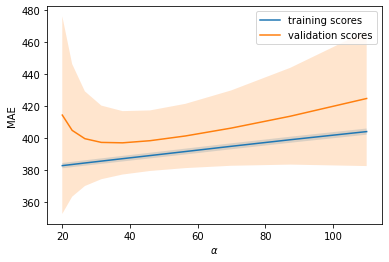

In [64]:

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

model = Ridge(random_state=4444) 
alphas = np.logspace(1,2,10) + 10 # Если коэффициент регуляризации мал, то значения получаются заоблочными
val_train, val_test = validation_curve(model, X_train_transformed_add, y_train_log, cv=cv,scoring=mean_absolute_exp_error, param_name='alpha', param_range=alphas)
plot_with_err(alphas, -val_train, label='training scores')
plot_with_err(alphas, -val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('MAE')
plt.legend();

Судя по кривым валидации, модель недообучилась: ошибки лежат близко друг к другу. 

In [65]:
# код из статьи на хабре
    
def plot_learning_curve(model, X,y):
    train_sizes = np.linspace(0.05, 1, 20)
      
    N_train, val_train, val_test = learning_curve(model,X, y, train_sizes=train_sizes, cv=5,scoring=mean_absolute_exp_error, random_state=4444)
    plot_with_err(N_train, -val_train, label='training scores')
    plot_with_err(N_train, -val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('MAE')
    plt.legend()


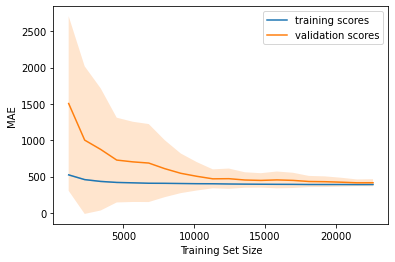

In [66]:
model = Ridge(alpha=52.140083,random_state=4444)
plot_learning_curve(model, X_train_transformed_add, y_train_log)

Кривые лежат близко друг к другу почти с самого начала. Вывод: наблюдений у нас достаточно, нужно двигаться в сторону усложнения модели

Приведем результаты различных моделей на тестовой выборке.
Как уже оговаривалось ранее, в качестве метрики используем MAE

In [67]:
pure_ridge = Ridge(random_state=4444, alpha=0.00001) # гребневая регрессия на исходных данных
pure_ridge.fit(X_train_transformed, y_train_log)
pure_ridge_score = mean_absolute_error(y_test, np.expm1(pure_ridge.predict(X_test_transformed)))
print('Ridge regression score: %f' % pure_ridge_score)
poly_ridge = Ridge(random_state=4444, alpha=52.140083) # гребневая регрессия с полиномиальными признаками
poly_ridge.fit(X_train_transformed_add, y_train_log)
poly_ridge_score = mean_absolute_error(y_test, np.expm1(poly_ridge.predict(X_test_transformed_add)))
print('Ridge regression score with poly features: %f' % poly_ridge_score)

Ridge regression score: 436.345103
Ridge regression score with poly features: 400.604093


Результаты близки к тем, что получались на кросс-валидации. Так что всё хорошо =)

In [83]:
#загрузка датасета тест 
data_diamonds_test = pd.read_csv('test.csv')
data_diamonds_test = data_diamonds_test[(data_diamonds_test['x'] != 0)&(data_diamonds_test['y'] != 0)&data_diamonds_test['z'] != 0]
data_diamonds_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.52,Fair,H,VS2,62.1,66.0,7.33,7.13,4.50
1,0.54,Premium,G,VS2,62.0,58.0,5.21,5.18,3.22
2,0.70,Premium,E,VS2,62.0,60.0,5.70,5.59,3.50
3,0.59,Ideal,E,VS2,62.2,58.0,5.35,5.39,3.34
4,0.86,Premium,F,SI2,61.8,58.0,6.12,6.15,3.79


In [84]:
data_diamonds_test = data_diamonds_test.values

In [88]:
data_diamonds_test

array([[1.52, 'Fair', 'H', ..., 7.33, 7.13, 4.5],
       [0.54, 'Premium', 'G', ..., 5.21, 5.18, 3.22],
       [0.7, 'Premium', 'E', ..., 5.7, 5.59, 3.5],
       ...,
       [0.7, 'Very Good', 'E', ..., 5.72, 5.65, 3.39],
       [0.58, 'Ideal', 'F', ..., 5.37, 5.33, 3.33],
       [0.71, 'Premium', 'H', ..., 5.71, 5.64, 3.56]], dtype=object)

In [85]:
from sklearn.preprocessing import PolynomialFeatures
# признаки с индексами 1,2,3 категориальные. Применим к ним ohe

diamonds_test_cut_ohe = label_bin.transform(data_diamonds_test[:,1])
diamonds_test_color_ohe = label_bin.transform(data_diamonds_test[:,2])
diamonds_test_clarity_ohe = label_bin.transform(data_diamonds_test[:,3])  

# carat, x и целевую переменную логарифмируем
log_vect = np.vectorize(np.log1p)
diamonds_test_сarat_log  = log_vect(data_diamonds_test[:,0]).reshape(-1,1)
diamonds_test_x_log  = log_vect(data_diamonds_test[:,6]).reshape(-1,1)

# масштабириуем вещественные признаки
diamonds_test_real = np.hstack((diamonds_test_сarat_log, diamonds_test_x_log, data_diamonds_test[:,[7,8,4,5]]))

diamonds_test_real_scaled = scaler.fit_transform(diamonds_test_real)

# В качестве дополнительных признаков будем рассматривать полиномиальные признаки
#Данные признаки должны улучшить качество линейной модели.

diamonds_test_additional = PolynomialFeatures().fit_transform(diamonds_test_real)
diamonds_test_additional_scaled = scaler.fit_transform(diamonds_test_additional)

# Объединяем все преобразованные признаки
diamonds_test_transformed = np.hstack((diamonds_test_real_scaled,diamonds_test_cut_ohe, diamonds_test_color_ohe, diamonds_test_clarity_ohe))

diamonds_test_transformed_add = np.hstack((diamonds_test_transformed, diamonds_test_additional_scaled))

In [100]:
poly_ridge.predict(diamonds_test_transformed_add[:,:-4])

array([8.41636446, 7.58842879, 7.69794028, ..., 7.4891209 , 7.75180719,
       7.89270269])